*   Autorius: Paulina Ivanauskaitė
*   LSP: 2213728
*   Variantas: Naudotos liūto, tigro ir leopardo klasės

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
import torch.optim as optim

classes = ["lion", "tiger", "leopard"]

Device: cuda:0


Dataset transformuoja nuotraukas, dirba kartu su dataloader. Įgyvendintos pagrindinės funkcijos reikalingos Dataset klasės inicializavimui (init, len ir getitem)

In [57]:
class BigCatDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = {'lion': 0, 'tiger': 1, 'leopard': 2}

        for cls in ['lion', 'tiger', 'leopard']:
            class_path = Path(f"/content/drive/MyDrive/ColabNotebooks/{base_dir}") / cls
            if class_path.exists():
                self.samples.extend([(str(p), self.class_to_idx[cls], cls) for p in class_path.glob('*.jpg')])
            else:
                print(f"Warning: Path {class_path} does not exist")

        print(f"Found {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, class_name = self.samples[idx]
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                if self.transform:
                    img = self.transform(img)
                return img, label, class_name
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros((3, 128, 128)), label, class_name

Nustatome transform

In [59]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Inicializuojame Dataset ir suskirstom jį į treniravimosi ir validacijos dalis.

In [60]:
dataset = BigCatDataset('big_cat_dataset', transform=transform)

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Vaidation set size: {len(validation_dataset)}")

Found 1000 images
Training set size: 800
Vaidation set size: 200


Inicializuojame du DataLoaders, vieną treniravimui, kitą validacijai.

In [61]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    prefetch_factor=2,
    persistent_workers=True,
    multiprocessing_context='fork'
)

validation_data_loader = DataLoader(
    validation_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    prefetch_factor=2,
    persistent_workers=True,
    multiprocessing_context='fork'
)

print(f"Using {train_data_loader.num_workers} workers")
print(f"Using {validation_data_loader.num_workers} workers")

Using 1 workers
Using 1 workers


Sukuriame paprastą konvoliucinį neuroninį tinklą.

In [63]:
import torch.nn as nn

class SimpleConvNet(torch.nn.Module):
    def __init__(self, in_shape, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_shape[0], 16, 3, padding='same')
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding='same')
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding='same')
        self.pool3 = torch.nn.MaxPool2d(2, 2)

        feature_size = in_shape[1] // 8 * in_shape[2] // 8 * 64

        self.fc1 = torch.nn.Linear(feature_size, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)

        self.flatten = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

sample_inputs, _, _ = next(iter(train_data_loader))
in_shape = sample_inputs[0].shape
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleConvNet(in_shape, len(classes)).to(device)

print(f"Model: {model.__class__.__name__}")
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Model: SimpleConvNet
Total parameters: 2,121,251
Trainable parameters: 2,121,251


Treniravimo funkcija

In [64]:
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    history = {
        'train_loss': [],
        'train_acc': []
    }

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            inputs, labels_unused, class_names = batch

            class_map = {'lion': 0, 'tiger': 1, 'leopard': 2}
            labels = torch.tensor([class_map[cls] for cls in class_names]).to(device)

            inputs = inputs.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    return model, history

Užkrauname seną ištreniruotą modelį ir atvaizduojam statistikas, arba treniruojame naują

Loading existing model located in big_cat_model.pth


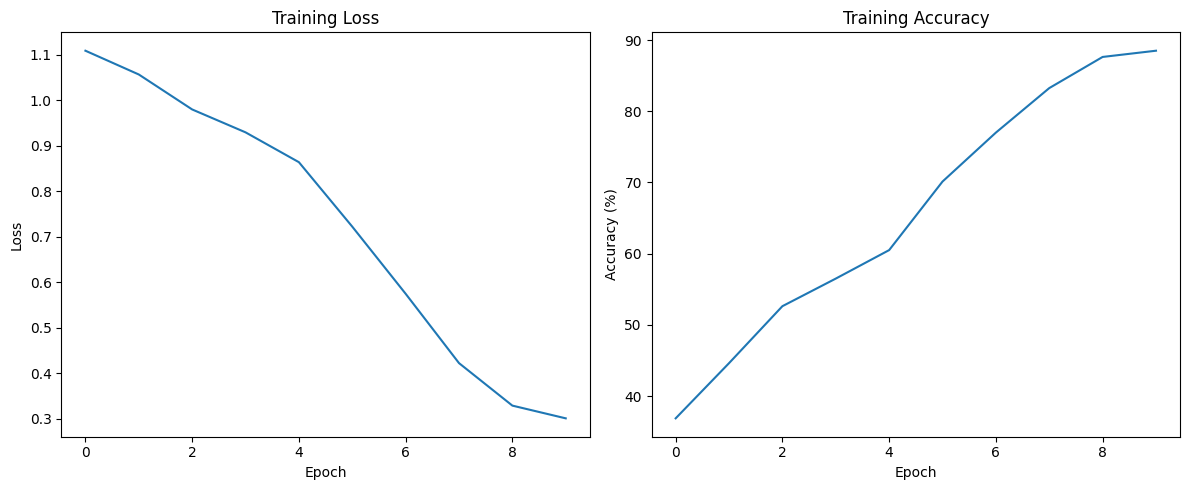

In [75]:
model_save_path = "big_cat_model.pth"

if os.path.exists(model_save_path):
    print(f"Loading existing model located in {model_save_path}")
    model.load_state_dict(torch.load(model_save_path, map_location=device))
else:
    print("No existing models, training new model")
    model, history = train_model(model, train_data_loader, num_epochs=10)

    torch.save(model.state_dict(), model_save_path)
    print(f"Newly trained model saved to {model_save_path}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

Vertiname ištreniruotą modelį, statistikas atvaizduojame.

Overall Metrics:
Accuracy: 0.4900
Precision (weighted): 0.5002
Recall (weighted): 0.4900
F1 Score (weighted): 0.4748

--------------------------------------------------

Per-Class Metrics:

Class: leopard
Precision: 0.5155
Recall: 0.7042
F1 Score: 0.5952
Accuracy: 0.7042 (50/71)

Class: lion
Precision: 0.4247
Recall: 0.4559
F1 Score: 0.4397
Accuracy: 0.4559 (31/68)

Class: tiger
Precision: 0.5667
Recall: 0.2787
F1 Score: 0.3736
Accuracy: 0.2787 (17/61)


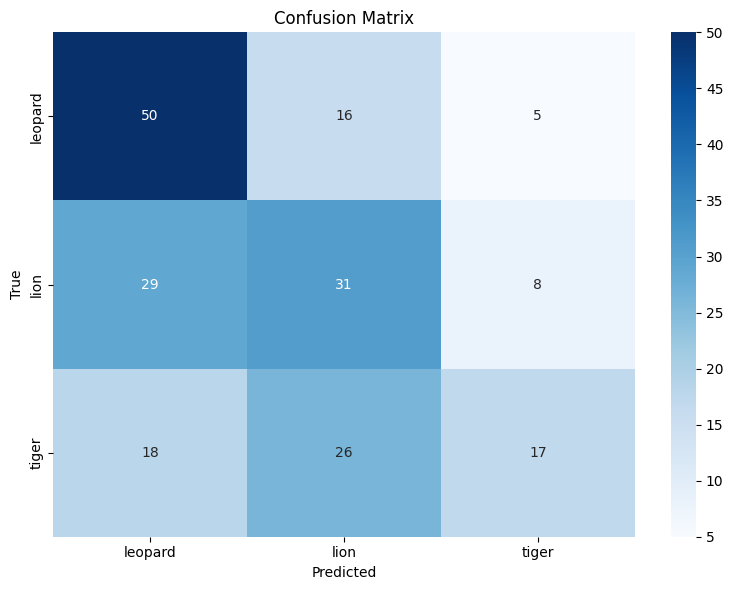

In [80]:
def evaluate_model(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, _, class_names = batch

            class_map = {'lion': 0, 'tiger': 1, 'leopard': 2}
            labels = torch.tensor([class_map[cls] for cls in class_names]).to(device)

            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted')
    recall_weighted = recall_score(all_labels, all_preds, average='weighted')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Overall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (weighted): {recall_weighted:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print("\n" + "-"*50 + "\n")

    print("Per-Class Metrics:")
    for i, class_name in enumerate(classes):
        print(f"\nClass: {class_name}")
        print(f"Precision: {precision_per_class[i]:.4f}")
        print(f"Recall: {recall_per_class[i]:.4f}")
        print(f"F1 Score: {f1_per_class[i]:.4f}")

        class_samples = sum(1 for label in all_labels if label == i)
        class_correct = sum(1 for pred, label in zip(all_preds, all_labels)
                            if pred == label and label == i)
        class_accuracy = class_correct / class_samples if class_samples > 0 else 0
        print(f"Accuracy: {class_accuracy:.4f} ({class_correct}/{class_samples})")

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': conf_matrix
    }

metrics = evaluate_model(model, validation_data_loader, classes)

Papildoma užduotis: similarity search
Naudojant kosinusų panašumą, apskaičiuojame nuotraukų panašumą ir rodome rezultatus. Pirmoje vietoje yra pavyzdinė nuotrauka, toliau eina 5 panašiausios į pavyzdinę, nuotraukos ir jų rezultatai

Extracting features...


Query image index: 2, Class: Leopard


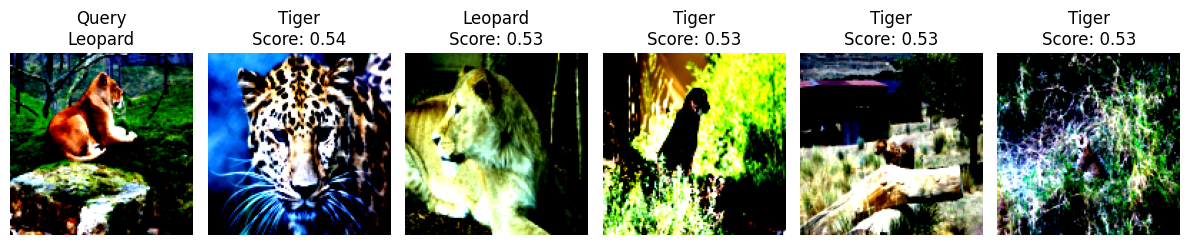

Extracting features...


Query image index: 36, Class: Leopard


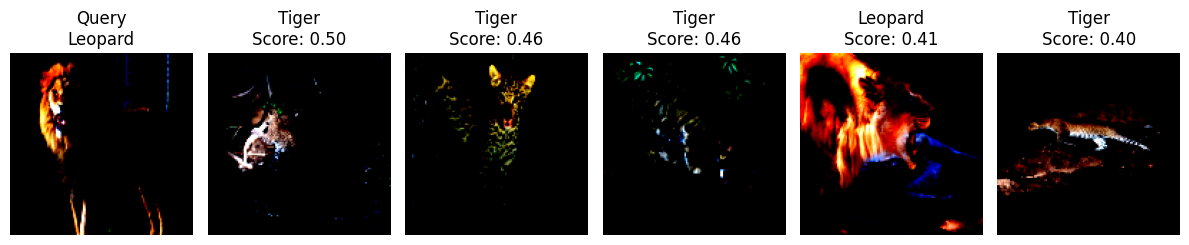

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

def extract_features_simple(model, loader, device):
    model.eval()
    all_features = []
    all_images = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            images, labels, class_names = batch

            images = images.to(device)

            x = model.conv1(images)
            x = torch.nn.functional.relu(x)
            x = model.pool1(x)
            x = model.conv2(x)
            x = torch.nn.functional.relu(x)
            x = model.pool2(x)
            features = model.flatten(x)

            all_features.extend(features.cpu().numpy())
            all_images.extend(images.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_features), np.array(all_images), np.array(all_labels)

def find_similar_simple(query_idx, features, images, labels, top_k=5):
    query_vector = features[query_idx].reshape(1, -1)

    similarities = cosine_similarity(query_vector, features)[0]

    top_indices = np.argsort(similarities)[::-1][1:top_k+1]

    return (
        images[top_indices],
        labels[top_indices],
        similarities[top_indices]
    )

def plot_similar_images(query_img, query_label, similar_imgs, similar_labels, similar_scores, class_names):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 6, 1)
    plt.imshow(np.transpose(query_img, (1, 2, 0)))
    plt.title(f"Query\n{class_names[query_label]}")
    plt.axis('off')

    for i in range(len(similar_imgs)):
        plt.subplot(1, 6, i+2)
        plt.imshow(np.transpose(similar_imgs[i], (1, 2, 0)))
        plt.title(f"{class_names[similar_labels[i]]}\nScore: {similar_scores[i]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def similarity_search_demo(model, loader, device, class_names, query_idx=None):
    print("Extracting features...")
    features, images, labels = extract_features_simple(model, loader, device)

    if query_idx is None:
        query_idx = np.random.randint(0, len(features))

    print(f"Query image index: {query_idx}, Class: {class_names[labels[query_idx]]}")

    similar_imgs, similar_labels, similar_scores = find_similar_simple(
        query_idx, features, images, labels
    )

    plot_similar_images(
        images[query_idx],
        labels[query_idx],
        similar_imgs,
        similar_labels,
        similar_scores,
        class_names
    )

class_names = ['Leopard', 'Lion', 'Tiger']
similarity_search_demo(model, validation_data_loader, device, class_names)
similarity_search_demo(model, validation_data_loader, device, class_names)